In [1]:
from time import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import itertools

from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# If we want to consider inf and -inf to be “NA” in computations, we can set 
pd.options.mode.use_inf_as_na = True

In [2]:
train_df = pd.read_csv('data/aps_failure_training_set.csv', skiprows=range(0, 20))
test_df = pd.read_csv('data/aps_failure_test_set.csv', skiprows=range(0, 20))

### Concat train and test dataframe

In [3]:
# replace classes neg to 0, pos to 1
# alternative index accesing train_df.iloc[:,0]

frames = [train_df, test_df]
df = pd.concat(frames)

df['class'] = df['class'].str.replace('neg','0')
df['class'] = df['class'].str.replace('pos','1')
cols = df.columns
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')

In [4]:
# split dataset into x and y
cols = df.columns.drop('class')
X = df[cols].values
y = df['class'].values

imp_train = Imputer(missing_values='NaN', strategy='median', axis=0)
imp_train = imp_train.fit(X)
# Impute each item
X_imp = imp_train.transform(X)

In [5]:
# LocalOutlierFactor
# http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html#sklearn.neighbors.LocalOutlierFactor
from sklearn.neighbors import LocalOutlierFactor
clf = LocalOutlierFactor(n_neighbors=20)
y_pred = clf.fit_predict(X_imp)
X = X_imp[y_pred > 0]
y = y[y_pred > 0]

In [6]:
# number of features with min costs (see ScaniaKNearestDimentions)
k = 96
# select features
X_imp_red = SelectKBest(chi2, k=91).fit_transform(X, y)

In [7]:
print('Class distribution of the whole set: {}'.format(Counter(y)))

Class distribution of the whole set: Counter({0: 67365, 1: 1035})


### Combination of over- and under-sampling
http://contrib.scikit-learn.org/imbalanced-learn/stable/combine.html#

In [8]:
from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=0)
t0 = time()
X_resampled, y_resampled = smote_enn.fit_sample(X_imp_red, y)
print(sorted(Counter(y_resampled).items()), "resampling time:",  round(time()-t0, 3))

[(0, 65513), (1, 67288)] resampling time: 162.382


In [9]:
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, random_state=0)

### K-Neighbors Classifier
http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [11]:
# train model
neigh = KNeighborsClassifier(n_neighbors=5)
t0 = time()
n_clf = neigh.fit(X_train, y_train) 
print('Train time', round(time()-t0, 3))
t1 = time()
y_pred = n_clf.predict(X_test)
print('Predict time', round(time()-t1, 3))

Train time 23.926
Predict time 29.082


### Evaluation

In [12]:
print('test labels: \n', sorted(Counter(y_test).items()))
print('predicted labels: \n', sorted(Counter(y_pred).items()))

test labels: 
 [(0, 16341), (1, 16860)]
predicted labels: 
 [(0, 16221), (1, 16980)]


In [13]:
acc = metrics.accuracy_score(y_pred, y_test)
print ("accuracy_score:", acc)

accuracy_score: 0.9959639769886449


In [14]:
# calculate null accuracy (for binary classification problems coded as 0/1)# calcul 
max(y_test.mean(), 1 - y_test.mean())

0.5078160296376615

Classification accuracy is the easiest classification metric to understand<br>
But, it does not tell you the underlying distribution of response values<br>
And, it does not tell you what "types" of errors your classifier is making<br>

In [15]:
# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# save confusion matrix and slice into four pieces
confusion = cnf_matrix
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
print("TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}".format(tp = TP, tn = TN, fp = FP, fn = FN))

TP: 16853, TN: 16214, FP: 127, FN: 7


In [16]:
Cost_1 = 10 
Cost_2 = 500
Total_cost = (Cost_1*FP + Cost_2*FN)/len(y_pred)

print("Total cost:", Total_cost)

Total cost: 0.1436703713743562


Confusion matrix, without normalization
[[16214   127]
 [    7 16853]]
Normalized confusion matrix
[[9.92e-01 7.77e-03]
 [4.15e-04 1.00e+00]]


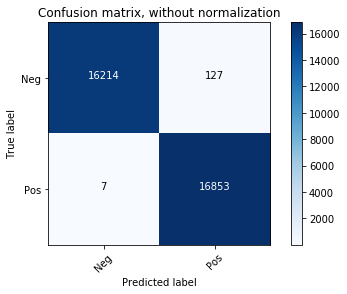

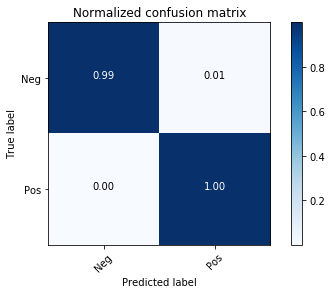

In [17]:
# Plot confusion matrix to evaluate the accuracy of a classification
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names = (['Neg', 'Pos'])
   
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

+ Every observation in the testing set is represented in exactly one box
+ It's a 2x2 matrix because there are 2 response classes
+ The format shown here is not universal

Basic terminology <br>

+ True Positives (TP): we correctly predicted that there is some failure
+ True Negatives (TN): we correctly predicted that there is no failure
+ False Positives (FP): we incorrectly predicted that there is some failure (a "Type I error")
+ False Negatives (FN): we incorrectly predicted that there is no failure (a "Type II error")

## Metrics computed from a confusion matrix¶
#### Classification Accuracy: Overall, how often is the classifier correct?

In [18]:
print((TP + TN) / float(TP + TN + FP + FN))
print(metrics.accuracy_score(y_test, y_pred))

0.9959639769886449
0.9959639769886449


#### Classification Error: Overall, how often is the classifier incorrect?

Also known as "Misclassification Rate"

In [19]:
print((FP + FN) / float(TP + TN + FP + FN))
print(1 - metrics.accuracy_score(y_test, y_pred))

0.00403602301135508
0.004036023011355083


#### Sensitivity: When the actual value is positive, how often is the prediction correct?

How "sensitive" is the classifier to detecting positive instances?
Also known as "True Positive Rate" or "Recall"

In [20]:
print(TP / float(TP + FN))
print(metrics.recall_score(y_test, y_pred))

0.9995848161328589
0.9995848161328589


#### Specificity: When the actual value is negative, how often is the prediction correct?

+ How "specific" (or "selective") is the classifier in predicting positive instances?

In [21]:
print(TN / float(TN + FP))

0.9922281378128633


#### False Positive Rate: When the actual value is negative, how often is the prediction incorrect?

In [22]:
print(FP / float(TN + FP))

0.00777186218713665


#### Precision: When a positive value is predicted, how often is the prediction correct?

+ How "precise" is the classifier when predicting positive instances?

In [23]:
print(TP / float(TP + FP))
print(metrics.precision_score(y_test, y_pred))

0.9925206124852768
0.9925206124852768


#### Conclusion:

+ Confusion matrix gives you a more complete picture of how your classifier is performing
+ Also allows you to compute various classification metrics, and these metrics can guide your model selection

#### Which metrics should you focus on?

+ Choice of metric depends on your business objective
+ Spam filter (positive class is "spam"): Optimize for precision or specificity because false negatives (spam goes to + the inbox) are more acceptable than false positives (non-spam is caught by the spam filter)
+ Fraudulent transaction detector (positive class is "fraud"): Optimize for sensitivity because false positives (normal transactions that are flagged as possible fraud) are more acceptable than false negatives (fraudulent transactions that are not detected)